In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from scipy import optimize
import cvxpy as cp

 # №1

$f(x_1, x_2) = \left( x_1 + x_2^2 \right)^2$

$x = ( 1, 0 )$, $p = ( -1, 1 )$ - is a descent direction

$\min\limits_{\alpha > 0} f(x + \alpha p)$

$p \cdot \nabla f < 0$

$$
\nabla f = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2} \right)
$$

$$
\nabla f = \left( 2x_1 + 2x_2^2, 4x_1x_2 + 4x_2^3 \right) = \left( 2, 0 \right)
$$

$$p \cdot \nabla f = -2 < 0$$

$$f(x + \alpha p) = f(x_1 - \alpha, x_2 + \alpha) = \left(x_1 - \alpha + (x_2 + \alpha)^2\right)^2$$

$$f(x+\alpha p) = (x_1 - \alpha + x_2^2 + 2\alpha x_2 + \alpha^2)^2$$

$$f(x + \alpha p) = (1 - \alpha + \alpha^2)^2$$

$$\min\limits_{\alpha > 0} (1 - a + \alpha^2)$$

$$-1 + 2\alpha = 0 \rightarrow \alpha = 0.5$$

# №2

$$y_i = e^{x_i}$$

$$x_i = -3 + 6 * \frac{i-1}{k-1}$$

$$k = 201$$

$$f(x) = \frac{a_0 + a_1x + a_2x^2}{1 + b_1x + b_2x^2}$$

$$\max_{i=1}^k |f(x_i) - y_i| \rightarrow \min$$

      fun: 0.02414599338255526
 hess_inv: array([[ 1.64231885e-03, -1.24377460e-03, -7.57288825e-04,
        -4.73385289e-04,  1.08636579e-04],
       [-1.24377460e-03,  3.10929338e-03,  1.33299144e-03,
         1.32618310e-03, -3.32491204e-04],
       [-7.57288825e-04,  1.33299144e-03,  7.95201713e-04,
         6.44662906e-04, -1.57926795e-04],
       [-4.73385289e-04,  1.32618310e-03,  6.44662906e-04,
         6.20700861e-04, -1.56218028e-04],
       [ 1.08636579e-04, -3.32491204e-04, -1.57926795e-04,
        -1.56218028e-04,  3.95155175e-05]])
      jac: array([-3.67328454e-08, -7.76101239e-08, -3.44065894e-07,  2.18651814e-06,
        6.79405363e-06])
  message: 'Optimization terminated successfully.'
     nfev: 403
      nit: 228
     njev: 403
   status: 0
  success: True
        x: array([ 1.009752  ,  0.61198069,  0.11355026, -0.41455087,  0.04849228])

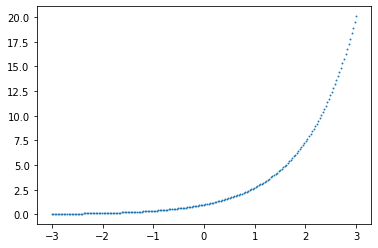

In [2]:
np.random.seed(42)

k = 201
X = np.linspace(-3, 3, k)
Y = np.exp(X)
plt.scatter(X, Y, s = 0.8)

def f(x, a):
    return (a[0] + a[1] * x + a[2] * x**2) / (1 + a[3] * x + a[4] * x**2)

def loss(a):
    P = 50
    return jnp.sum((f(X, a) - Y)**P) ** (1/P)

a0 = np.random.normal(size=5)
res = optimize.minimize(
    loss, # Loss function
    a0,   # Initial value
    jac  = jax.grad(loss),
    method = 'BFGS'
)
res

In [3]:
np.max(f(X, res.x) - Y)

0.023256293420192774

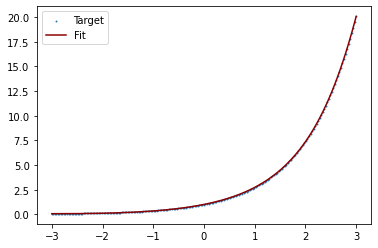

In [4]:

plt.scatter(X, Y, s=0.8, label='Target')
plt.plot(X, f(X, res.x), color='darkred', label="Fit")
plt.legend()

# №3*

In [5]:
import h5py

def get_data(file_path: str):
    with h5py.File(file_path, "r") as f:
        dr, r = f["dr"]["block0_values"][()], f["r"]["block0_values"][()]
        ijk = f["measurements"]["block0_values"][()]
        theta = f["measurements"]["block1_values"][()]
        f.close()
    return dr, ijk, theta, r

dr, ijk, theta, r = get_data("../HW3/data/localization_data_1.hdf")
dr, ijk, theta, r

(array([[-0.0392699,  0.       ],
        [ 0.0392699, -0.0392699],
        [ 0.       ,  0.0392699]]),
 array([[1, 2, 3]], dtype=int32),
 array([[0.706858]]),
 array([[-1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.]]))

# №4

$ u_0 = argmin _{u∈R^d, |u|=1} u^T A u $, A  - симметричная

In [6]:
def get_symm_matrix(N: int):
    b = np.random.random_integers(-10,10, size=(N,N))
    return (b + b.T)/2
A = get_symm_matrix(10)
A

/var/folders/33/pml9j82x2hz0y5wjjt4ws6sm0000gn/T/ipykernel_39607/3477379076.py:2: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  b = np.random.random_integers(-10,10, size=(N,N))


array([[  0. ,  -4.5,   9. ,   0. ,  -1. ,  -8.5,   7.5,   0.5,  -1. ,
         -4.5],
       [ -4.5,  10. ,  -4.5,  -3. ,  -1. ,   0.5,   1.5,   3.5,   2. ,
          1. ],
       [  9. ,  -4.5,   9. ,  -2.5,  -1. ,   3.5,  -3.5,   4. ,   3. ,
         -4. ],
       [  0. ,  -3. ,  -2.5,   7. ,  -5. ,   1.5,  -3. ,   6.5,   5. ,
         -3. ],
       [ -1. ,  -1. ,  -1. ,  -5. ,   3. ,   6.5,  -5. ,   4.5,  -3. ,
         -5. ],
       [ -8.5,   0.5,   3.5,   1.5,   6.5,   1. ,   0.5,  -5.5,  -7.5,
          2. ],
       [  7.5,   1.5,  -3.5,  -3. ,  -5. ,   0.5,   5. ,  -1. ,  -0.5,
         -2.5],
       [  0.5,   3.5,   4. ,   6.5,   4.5,  -5.5,  -1. ,  -2. , -10. ,
         -4.5],
       [ -1. ,   2. ,   3. ,   5. ,  -3. ,  -7.5,  -0.5, -10. ,  -6. ,
          2. ],
       [ -4.5,   1. ,  -4. ,  -3. ,  -5. ,   2. ,  -2.5,  -4.5,   2. ,
         -6. ]])

In [7]:
# для сверки
eigenvalues = np.linalg.eigvals(A)
print(sorted(eigenvalues)[:2])

[-25.628460896649784, -12.201605626167455]


# №5 

In [12]:
import jax.numpy as jnp
from jax import grad, jit

setup = np.array(list(pd.read_pickle("data/data_sensors.pickle").values()))
# все вектора двухмерные

# Define the function to minimize
def loss(x):
    total_loss = 0
    i, j, n = setup[:, 0], setup[:, 1], setup[:, 2]
    for k in range(len(n)):
        total_loss += jnp.linalg.norm((x[i[k]] - x[j[k]]) - n[k]*(x[i[k]] - x[j[k]] * n[k]))
    return jnp.sum(total_loss)

grad_loss_function = grad(loss)

x0 = np.array([np.array([0.1, -0.1]) for x in range(len(setup[:, 2]))])
res = optimize.minimize(
    loss, # Loss function
    x0,   # Initial value
    jac  = jax.grad(loss),
    method = 'BFGS'
)

/var/folders/33/pml9j82x2hz0y5wjjt4ws6sm0000gn/T/ipykernel_39607/715153478.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  setup = np.array(list(pd.read_pickle("data/data_sensors.pickle").values()))
/var/folders/33/pml9j82x2hz0y5wjjt4ws6sm0000gn/T/ipykernel_39607/715153478.py:18: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = optimize.minimize(


In [13]:
res

      fun: 3.073856516350977e-151
 hess_inv: array([[ 3.07239645e-151,  7.14456859e-153,  1.21962314e-151, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 7.14456859e-153,  7.45632534e-153, -3.61837074e-153, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 1.21962314e-151, -3.61837074e-153,  1.26250196e-151, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         1.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  1.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  1.00000000e+000]])
      jac: array([ -0.90361241,   4.54336944,  -1.71875088,  -2.39531143,
         7.25851963,   8.54066499,  12.64110939, -14.98245965,
        -9.49523179,  -5.

# №6

In [ ]:
# R^2_{++} -- set of positive real numbers
x = np.linspace(0, 5, 400)
y = np.linspace(0, 5, 400)
X, Y = np.meshgrid(x, y)
Z1 = X / Y
Z2 = X * Y

# Plot x/y 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z1, levels=[-np.inf, 1], colors='skyblue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Set where X/Y < 1')

# Plot x*y 
plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z2, levels=[-np.inf, 1], colors='lightcoral')
plt.plot([0.1, 3], [3, 0.1], color = "black") # контрпример, множество не выпуклое
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Set where X*Y < 1')

plt.tight_layout()
plt.show()
# a, b, d -- выпуклые, d -- не выпуклое


# №7

(a) f$(x, y) = x^2/y, y>0$

$$\nabla^2 f  = \left( \begin{matrix} \frac{2}{y} & \frac{-2x}{y^2}  \\ \frac{-2x}{y^2}& \frac{2x^2}{y^3} \end{matrix} \right)$$

$\forall v$: $v^T \nabla^2 f(x) v = \frac{2}{y} \left( v_1^2 + \frac{x^2 v_2^2}{y^2} - \frac{2v_1v_2x}{y} \right) = \frac{2}{y} \left( v_1 - \frac{v_2 x}{y} \right)^2 > 0$


(b) $f(x) = \left(\prod^n_{k=1}x_k \right) ^{1/n}$

$$ $$

(c) $f(x) = ln \sum_{k=1}^n e^{x_k}$, $x \in R^n$

$$\nabla^2 f = \left( \begin{matrix} \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1\partial x_2} & ... \\ ... & ... & ... \end{matrix} \right)$$

$$\frac{\partial^2 f}{\partial x_i^2} = \frac{\partial}{\partial x_i}\left(\frac{1}{\sum_{k=1}^n e^{x_k}} e^{x_i}\right)$$

$$\frac{\partial^2 f}{\partial x_i^2} = \frac{1}{\sum_{k=1}^n e^{x_k}}e^{x_i} - \frac{1}{\left(\sum_{k=1}^n e^{x_k}\right)^2}e^{2x_i}$$

$$\frac{\partial^2 f}{\partial x_i\partial x_j} = \frac{\partial}{\partial x_j} \left( \frac{1}{\sum_{k=1}^ne^{x_k}} e^{x_i} \right)$$

$$\frac{\partial^2 f}{\partial x_i\partial x_j} = -\frac{1}{\left(\sum e^{x_k}\right)^2}e^{x_i + x_j}$$

$$\xi = \left( e^{x_1}, e^{x_2}, ... \right)$$

$$\nabla^2 f = \frac{1}{\vec 1 \cdot \xi} \text{diag} (\xi) - \frac{1}{\left(\vec 1 \cdot \xi\right)^2} \xi\xi^T$$

$\forall v$: $v^T \nabla^2 f(x) v \ge 0$

$$\frac{\sum \xi_i v_i^2}{\sum \xi_i} - \frac{(\sum v_i \xi_i)^2}{\left(\sum \xi_i\right)^2} \ge 0$$

# №8

# №10

In [ ]:
exq10_data = np.load('data/data_fit.npz')
x, y = exq10_data["x"], exq10_data["y"]
A = np.vstack([x**2, x, np.ones_like(x)]).T
coefficients_lstsq, _, _, _ = np.linalg.lstsq(A, y, rcond=None)

a = cp.Variable()
b = cp.Variable()
c = cp.Variable()

cp.Problem(cp.Minimize(cp.abs(cp.sum(a*x**2 + b*x + c - y)))).solve()
coefficients_l1 = [a.value, b.value, c.value]

cp.Problem(cp.Minimize(cp.sum_squares(a*x**2 + b*x + c - y))).solve()
coefficients_l2 = [a.value, b.value, c.value]


x_fit = np.linspace(min(x), max(x), 100)
y_fit_lstsq = coefficients_lstsq[0] * x_fit**2 + coefficients_lstsq[1] * x_fit + coefficients_lstsq[2]
y_fit_l1 = coefficients_l1[0] * x_fit**2 + coefficients_l1[1] * x_fit + coefficients_l1[2]
y_fit_l2 = coefficients_l2[0] * x_fit**2 + coefficients_l2[1] * x_fit + coefficients_l2[2]


# Plot the data points and the fitted polynomial curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Data Points')
plt.plot(x_fit, y_fit_lstsq, color='red', label='LSTQ MSE')
plt.plot(x_fit, y_fit_l1, color='green', label='CVXPY MAE')
plt.plot(x_fit, y_fit_l2, color='blue', label='CVXPY MSE')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting a Square Polynomial')
plt.legend()
plt.grid(True)
plt.show()

# оптимизировать MSE по сравнению с MAE лучше
# с MSE CVXPY и np.linalg.lstsq справились одинаково

# №11

In [ ]:
data = np.load('data/data_linprog.npz')
X = data['X']
y = data['y']

n, k = X.shape

# Formulate the linear program to minimize the sum of absolute values of elements in 'a'
c = np.ones(2*k)  # Objective function to minimize the sum of absolute values
A_eq = np.hstack((X, -X))  # Coefficients of xi and -xi in the equality constraint
b_eq = y  # RHS of the equality constraint

# Bounds for each element of 'a' to be between -inf and +inf
bounds = [(-100, 100) for _ in range(2*k)]

# Solve the linear program
res = sp.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Extract the optimal vector 'a'
optimal_a = res.x[:k] - res.x[k:]

# Count the number of non-zero elements in the optimal 'a'
non_zero_elements = np.count_nonzero(optimal_a)

print(f"The optimal 'a' has {non_zero_elements} non-zero elements.")
print(f"a norm {np.sum(abs(optimal_a))}")
print(f"Are equal: {np.allclose(X@optimal_a, y, atol=5)}")

# №12

$$y_i = a \cdot x_i + \epsilon_i$$

Minimize: $L_n(a) = \sum\limits_i \left( y_i - a \cdot x_i \right)^2 + \lambda \|a\|_n$

In [ ]:
ex7_data_path = 'data/data_regr.npz'
ex7_data = np.load(ex7_data_path)
ex7_data

In [ ]:
X = ex7_data['X']
y = ex7_data['y']
X.shape, y.shape

In [ ]:
n = y.shape[0]
k = X.shape[1]
n,k

In [ ]:
def solve(l):
    a = cp.Variable(k)
    loss = cp.sum((y - X @ a)**2) + l * cp.norm(a, 2)
    objective = cp.Minimize(loss)
    problem = cp.Problem(objective, None)
    return problem.solve(), a.value

In [ ]:
ls = np.linspace(0, 5000, 500)
rs = np.zeros(ls.shape)
an = np.zeros(rs.shape)
for i in range(ls.shape[0]):
    print(f"{i=}", end='\r')
    _, a1 = solve(ls[i])
    rs[i] = np.linalg.norm(y - X @ a1)
    an[i] = np.linalg.norm(a1)

plt.plot(ls, rs, label='|y - Xa|')
plt.plot(ls, an, label='|a|')
plt.legend()

# №13

Find: $r \in R^2$ - source

Given $r_1, r_2, ..., r_m \in R^2$ - detectors

Given $d_1, d_2, ..., d_m \in R$ - distances $\|r-r_k\|_2$

$$L(r) = \sum\left( \|r-r_k\|_2^2 - d_k^2 \right)^2$$

$\min\limits_{r,t} \sum(t + \|r_k\|^2  2r\cdot r_k -d_k^2)^2$ s.t. $\|r\|_2^2=t$

$\bar L (x,y,t) = \sum(t + \|r_k\|^2 - 2r \cdot r_k - d_k^2)^2 + \lambda (\|r\|^2 - t)$

# №14